# Renfe Ticket Pricing Analysis

Data set available at
https://www.kaggle.com/thegurus/spanish-high-speed-rail-system-ticket-pricing


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import plotly.offline as py
#import plotly.graph_objs as go
import string
import os
#from sklearn.decomposition import PCA

# This next import is for some date functions I created
import timefuns as tf

## Methods to extract time and date data

In [2]:
def getHour(date):
    return int(date[11:13])

def getHourFloat(date):
    return float(date[11:13]) + float(date[14:16])/60

def getMonth(date):
    return int(date[5:7])

def getDate(date):
    return date[:10]

def weekday(date):
    month = int(date[5:7])
    day = int(date[8:10])
    
    daysPerMonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    weekdays = ['tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'monday']
    
    daysSince = day - 1
    i = month - 1
    while i > 0:
        daysSince = daysSince + daysPerMonth[i-1]
        i = i - 1
        
    return weekdays[daysSince % 7]

## Importing the raw data

### Looking at the columns

In [3]:
cols = list(pd.read_csv("renfe.csv", nrows =1))
print(cols)

['Unnamed: 0', 'insert_date', 'origin', 'destination', 'start_date', 'end_date', 'train_type', 'price', 'train_class', 'fare']


### Reading the data file

In [4]:
raw_data = pd.read_csv("renfe.csv", dtype = 'str', usecols = [i for i in cols if i != 'Unnamed: 0'])

In [5]:
raw_data.shape

(2579771, 9)

In [6]:
raw_data.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.4,Turista,Promo
2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.3,Turista,Promo
3,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.4,Preferente,Promo
4,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:30:00,2019-05-29 11:14:00,ALVIA,NaN,Turista,Promo


In [7]:
raw_data['destination'][123456]

'MADRID'

### We explore the different types of trains, fares, classes, and destinations

In [8]:
classes = raw_data['train_class'].unique().tolist()
print(classes)

['Turista', 'Preferente', 'Turista con enlace', 'Turista Plus', nan, 'Cama G. Clase', 'Cama Turista']


In [9]:
trainTypes = raw_data['train_type'].unique().tolist()
print(trainTypes)

['AV City', 'AVE', 'ALVIA', 'INTERCITY', 'MD-LD', 'MD', 'LD-MD', 'LD', 'MD-AVE', 'TRENHOTEL', 'AVE-LD', 'REGIONAL', 'AVE-MD', 'R. EXPRES', 'AVE-TGV', 'LD-AVE']


In [10]:
fares = raw_data['fare'].unique().tolist()
print(fares)

['Promo', 'Flexible', 'Promo +', nan, 'Individual-Flexible', 'Adulto ida', 'Mesa', 'Grupos Ida']


In [11]:
origins = raw_data['origin'].unique().tolist()
destinations = raw_data['destination'].unique().tolist()
print(origins)
print(destinations)

['MADRID', 'SEVILLA', 'PONFERRADA', 'BARCELONA', 'VALENCIA']
['SEVILLA', 'MADRID', 'VALENCIA', 'BARCELONA', 'PONFERRADA']


In [12]:
stage = raw_data.loc[(raw_data['origin'] == 'MADRID') & 
                     (raw_data['destination'] == 'BARCELONA') &
                     (raw_data['train_type'] == 'AVE')]
stage = stage.dropna(subset = ['price'])

In [13]:
print(stage.shape)
stage.head(10)

(407656, 9)


,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
1906,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 06:20:00,2019-04-27 09:29:00,AVE,86.8,Preferente,Promo
1907,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 07:30:00,2019-04-27 10:40:00,AVE,75.4,Turista,Promo
1908,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 08:30:00,2019-04-27 11:15:00,AVE,107.7,Turista,Flexible
1909,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 09:30:00,2019-04-27 12:34:00,AVE,107.7,Turista,Flexible
1910,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 10:30:00,2019-04-27 13:15:00,AVE,80.15,Turista Plus,Promo
1911,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 11:30:00,2019-04-27 14:40:00,AVE,102.15,Turista Plus,Promo
1912,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 12:30:00,2019-04-27 15:30:00,AVE,107.7,Turista,Flexible
1914,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 15:30:00,2019-04-27 18:40:00,AVE,69.8,Turista Plus,Promo
1915,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 16:30:00,2019-04-27 19:15:00,AVE,66.75,Turista,Promo
1916,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 17:30:00,2019-04-27 20:40:00,AVE,58.15,Turista,Promo


We check the first date

In [14]:
min(stage['start_date'])

'2019-04-12 05:50:00'

We add a 'weekday' column, that we will use for further analysis.

In [15]:
stage['weekday'] = stage['start_date'].apply(tf.weekday)
stage.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare,weekday
1906,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 06:20:00,2019-04-27 09:29:00,AVE,86.8,Preferente,Promo,saturday
1907,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 07:30:00,2019-04-27 10:40:00,AVE,75.4,Turista,Promo,saturday
1908,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 08:30:00,2019-04-27 11:15:00,AVE,107.7,Turista,Flexible,saturday
1909,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 09:30:00,2019-04-27 12:34:00,AVE,107.7,Turista,Flexible,saturday
1910,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 10:30:00,2019-04-27 13:15:00,AVE,80.15,Turista Plus,Promo,saturday


We separate the two fare types

In [16]:
stageProm = stage.loc[stage['fare'] == 'Promo']
stageFlex = stage.loc[stage['fare'] == 'Flexible']

These functions compute the average and standard deviation in ticket prices of each train trip per weekday.

In [17]:
def averagePerWeekday(stage):
    result = {'monday': 0.0, 'tuesday': 0.0, 'wednesday': 0.0, 'thursday': 0.0, 
              'friday': 0.0, 'saturday': 0.0, 'sunday': 0.0}
    for day in result.keys():
        result[day] = stage.loc[stage['weekday'] == day]['price'].astype(float).mean()
        
    return result

def stdPerWeekday(stage):
    result = {'monday': 0.0, 'tuesday': 0.0, 'wednesday': 0.0, 'thursday': 0.0, 
              'friday': 0.0, 'saturday': 0.0, 'sunday': 0.0}
    for day in result.keys():
        result[day] = stage.loc[stage['weekday'] == day]['price'].astype(float).std()
        
    return result
    

We compute overall averages per weekday, as well as separate ones for each train class

In [18]:
apw = averagePerWeekday(stageProm)
apwTur = averagePerWeekday(stageProm.loc[stageProm['train_class'] == 'Turista'])
apwTurPlus = averagePerWeekday(stageProm.loc[stageProm['train_class'] == 'Turista Plus'])
apwPref = averagePerWeekday(stageProm.loc[stageProm['train_class'] == 'Preferente'])

We graph the results

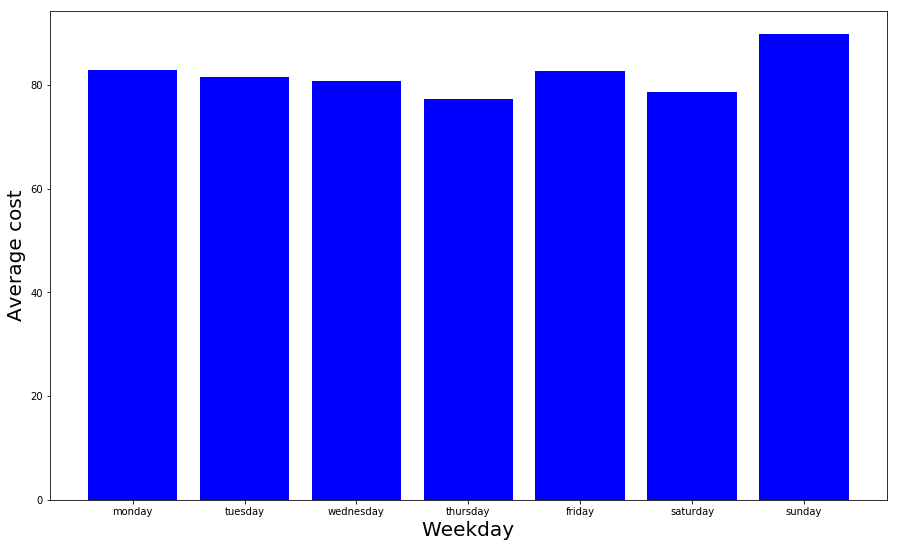

In [19]:
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
ax.bar(list(apw.keys()), apw.values(), color = 'blue')
ax.set_xlabel('Weekday',fontsize=20)
ax.set_ylabel('Average cost',fontsize=20)
#ax.legend(loc='upper left')
#ax.set_xlim(1870, 2018)
#ax.grid(True)
#ax.annotate('A',
#            xy=(1900, 30000), xycoords='data',
#            xytext=(-15, 25), textcoords='offset points',
#            arrowprops=dict(facecolor='black', shrink=0.05, width = 0.5),
#            horizontalalignment='right', verticalalignment='bottom')
plt.show()

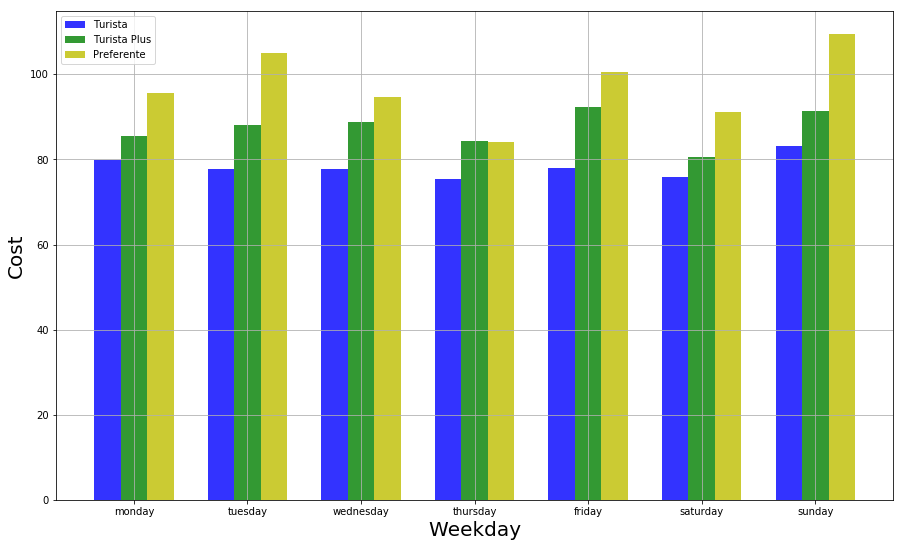

In [20]:
n_groups = 7
meansTur = list(apwTur.values())
meansTurPlus = list(apwTurPlus.values())
meansPref = list(apwPref.values())
    
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
index = np.arange(n_groups)
bar_width = 0.7/3
opacity = 0.8

rects1 = plt.bar(index, meansTur, bar_width,
alpha=opacity,
color='b',
label='Turista')

rects2 = plt.bar(index + bar_width, meansTurPlus, bar_width,
alpha=opacity,
color='g',
label='Turista Plus')

rects3 = plt.bar(index + 2*bar_width, meansPref, bar_width,
alpha=opacity,
color='y',
label='Preferente')

plt.xticks(index + bar_width, list(apwPref.keys()))
ax.grid(True)
plt.legend()
plt.xlabel('Weekday', fontsize = 20)
plt.ylabel('Cost', fontsize = 20)
plt.show()

We see that, generally, the order of classes is satisfied, from Turista being the lowest cost and Preferente being the costliest.

What we don't see that clearly, is any change in price per weekday.

We will see if this has to do with the time period of each trip. Trains on the weekend and around the working day should cost more and very early or very late trains should cost less.

In [21]:
stageTur = stageProm.loc[stageProm['train_class'] == 'Turista']

apwTurEM = averagePerWeekday(stageTur.loc[stage['start_date'].apply(tf.getHour) < 8])
apwTurLM = averagePerWeekday(stageTur.loc[(stage['start_date'].apply(tf.getHour) < 12) &
                                          (stage['start_date'].apply(tf.getHour) >= 8)])
apwTurEA = averagePerWeekday(stageTur.loc[(stage['start_date'].apply(tf.getHour) < 16) &
                                          (stage['start_date'].apply(tf.getHour) >= 12)])
apwTurLA = averagePerWeekday(stageTur.loc[(stage['start_date'].apply(tf.getHour) < 19) &
                                          (stage['start_date'].apply(tf.getHour) >= 16)])
apwTurEE = averagePerWeekday(stageTur.loc[(stage['start_date'].apply(tf.getHour) < 22) &
                                          (stage['start_date'].apply(tf.getHour) >= 19)])
apwTurLE = averagePerWeekday(stageTur.loc[(stage['start_date'].apply(tf.getHour) >= 22)])

spwTurEM = stdPerWeekday(stageTur.loc[stage['start_date'].apply(tf.getHour) < 8])
spwTurLM = stdPerWeekday(stageTur.loc[(stage['start_date'].apply(tf.getHour) < 12) &
                                          (stage['start_date'].apply(tf.getHour) >= 8)])
spwTurEA = stdPerWeekday(stageTur.loc[(stage['start_date'].apply(tf.getHour) < 16) &
                                          (stage['start_date'].apply(tf.getHour) >= 12)])
spwTurLA = stdPerWeekday(stageTur.loc[(stage['start_date'].apply(tf.getHour) < 19) &
                                          (stage['start_date'].apply(tf.getHour) >= 16)])
spwTurEE = stdPerWeekday(stageTur.loc[(stage['start_date'].apply(tf.getHour) < 22) &
                                          (stage['start_date'].apply(tf.getHour) >= 19)])
spwTurLE = stdPerWeekday(stageTur.loc[(stage['start_date'].apply(tf.getHour) >= 22)])

We graph the results

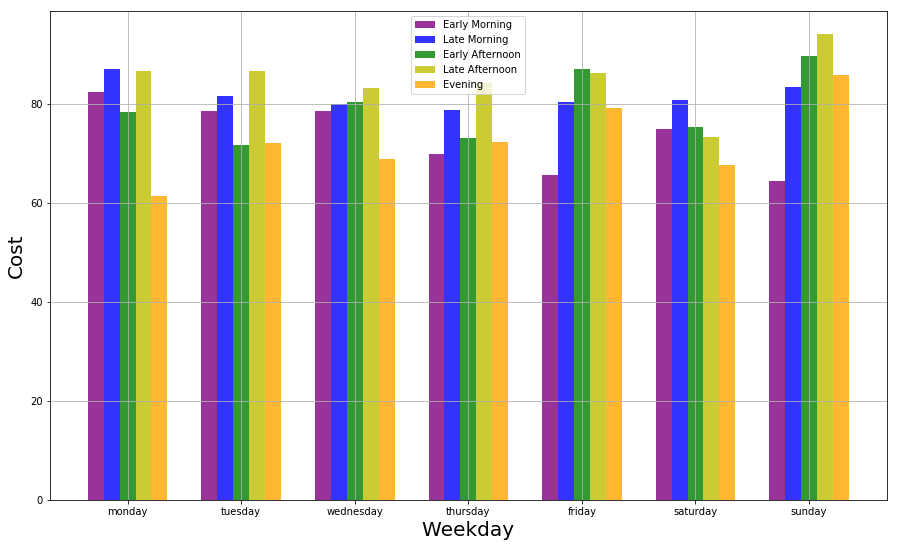

In [22]:
n_groups = 7
meansTurEM = list(apwTurEM.values())
meansTurLM = list(apwTurLM.values())
meansTurEA = list(apwTurEA.values())
meansTurLA = list(apwTurLA.values())
meansTurEE = list(apwTurEE.values())
#meansTurLE = list(apwTurLE.values())
    
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
index = np.arange(n_groups)
bar_width = 0.7/5
opacity = 0.8

rects1 = plt.bar(index, meansTurEM, bar_width,
alpha=opacity,
color='purple',
label='Early Morning')

rects2 = plt.bar(index + bar_width, meansTurLM, bar_width,
alpha=opacity,
color='b',
label='Late Morning')

rects3 = plt.bar(index + 2*bar_width, meansTurEA, bar_width,
alpha=opacity,
color='g',
label='Early Afternoon')

rects4 = plt.bar(index + 3*bar_width, meansTurLA, bar_width,
alpha=opacity,
color='y',
label='Late Afternoon')

rects5 = plt.bar(index + 4*bar_width, meansTurEE, bar_width,
alpha=opacity,
color='orange',
label='Evening')

# rects6 = plt.bar(index + 5*bar_width, meansTurLE, bar_width,
# alpha=opacity,
# color='r',
# label='Preferente')

plt.xticks(index + 2*bar_width, list(apwPref.keys()))
ax.grid(True)
plt.legend()
plt.xlabel('Weekday', fontsize = 20)
plt.ylabel('Cost', fontsize = 20)
plt.show()

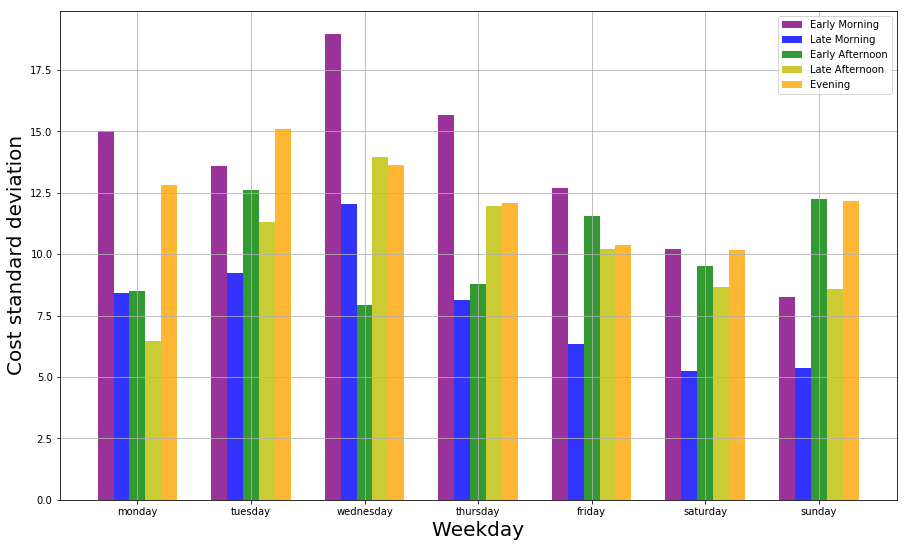

In [23]:
n_groups = 7
meansTurEM = list(spwTurEM.values())
meansTurLM = list(spwTurLM.values())
meansTurEA = list(spwTurEA.values())
meansTurLA = list(spwTurLA.values())
meansTurEE = list(spwTurEE.values())
#meansTurLE = list(apwTurLE.values())
    
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
index = np.arange(n_groups)
bar_width = 0.7/5
opacity = 0.8

rects1 = plt.bar(index, meansTurEM, bar_width,
alpha=opacity,
color='purple',
label='Early Morning')

rects2 = plt.bar(index + bar_width, meansTurLM, bar_width,
alpha=opacity,
color='b',
label='Late Morning')

rects3 = plt.bar(index + 2*bar_width, meansTurEA, bar_width,
alpha=opacity,
color='g',
label='Early Afternoon')

rects4 = plt.bar(index + 3*bar_width, meansTurLA, bar_width,
alpha=opacity,
color='y',
label='Late Afternoon')

rects5 = plt.bar(index + 4*bar_width, meansTurEE, bar_width,
alpha=opacity,
color='orange',
label='Evening')

# rects6 = plt.bar(index + 5*bar_width, meansTurLE, bar_width,
# alpha=opacity,
# color='r',
# label='Preferente')

plt.xticks(index + 2*bar_width, list(apwPref.keys()))
ax.grid(True)
plt.legend()
plt.xlabel('Weekday', fontsize = 20)
plt.ylabel('Cost standard deviation', fontsize = 20)
plt.show()

We see that some of the data is very noisy and it is hard to find any conclusion.

Next we look at the average ticket cost on Wednesdays at every 30 minute time window to get an idea what creates this noise

In [24]:
stageTurWed = stageProm.loc[(stageProm['train_class'] == 'Turista') &
                            (stageProm['weekday'] == 'wednesday')]

times = list(np.linspace(5.0, 22.5, 36))
costs = []
stdcosts = []
for t in times:
    costs.append(stageTurWed.loc[(stage['start_date'].apply(tf.getHourFloat) < t + 0.5) &
                                 (stage['start_date'].apply(tf.getHourFloat) >= t)] \
                            ['price'].astype(float).mean())
    stdcosts.append(stageTurWed.loc[(stage['start_date'].apply(tf.getHourFloat) < t + 0.5) &
                                    (stage['start_date'].apply(tf.getHourFloat) >= t)] \
                               ['price'].astype(float).std())

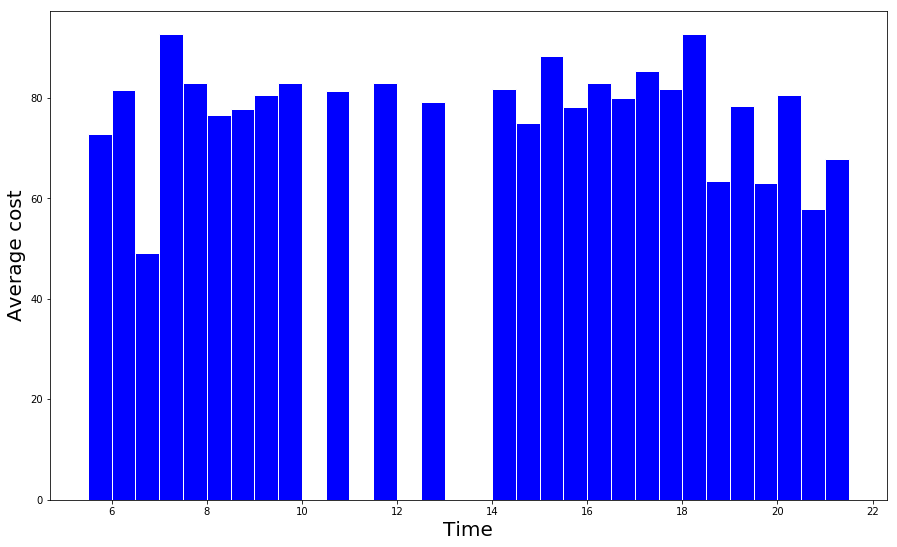

In [25]:
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
ax.bar(times, costs, 0.5, color = 'blue', edgecolor = 'white', align = 'edge')
ax.set_xlabel('Time',fontsize=20)
ax.set_ylabel('Average cost',fontsize=20)
#ax.legend(loc='upper left')
#ax.set_xlim(1870, 2018)
#ax.grid(True)
#ax.annotate('A',
#            xy=(1900, 30000), xycoords='data',
#            xytext=(-15, 25), textcoords='offset points',
#            arrowprops=dict(facecolor='black', shrink=0.05, width = 0.5),
#            horizontalalignment='right', verticalalignment='bottom')
plt.show()

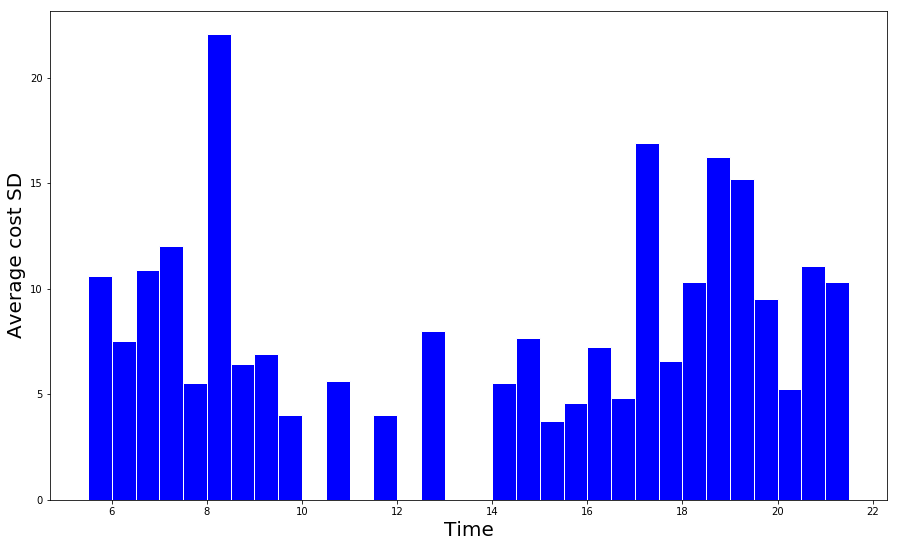

In [26]:
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
ax.bar(times, stdcosts, 0.5, color = 'blue', edgecolor = 'white', align = 'edge')
ax.set_xlabel('Time',fontsize=20)
ax.set_ylabel('Average cost SD',fontsize=20)
#ax.legend(loc='upper left')
#ax.set_xlim(1870, 2018)
#ax.grid(True)
#ax.annotate('A',
#            xy=(1900, 30000), xycoords='data',
#            xytext=(-15, 25), textcoords='offset points',
#            arrowprops=dict(facecolor='black', shrink=0.05, width = 0.5),
#            horizontalalignment='right', verticalalignment='bottom')
plt.show()

There is a very high variation period between 8:00 and 8:30. Let's look at the data in more detail

In [27]:
stageTurWed.loc[(stage['start_date'].apply(tf.getHourFloat) < 8.0 + 0.5) &
                                    (stage['start_date'].apply(tf.getHourFloat) >= 8.0)].head(12)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare,weekday
2255,2019-04-19 06:03:47,MADRID,BARCELONA,2019-05-22 08:00:00,2019-05-22 10:30:00,AVE,100.4,Turista,Promo,wednesday
2256,2019-04-19 06:03:47,MADRID,BARCELONA,2019-05-22 08:20:00,2019-05-22 11:05:00,AVE,40.95,Turista,Promo,wednesday
2610,2019-04-19 06:05:30,MADRID,BARCELONA,2019-05-08 08:00:00,2019-05-08 10:30:00,AVE,100.4,Turista,Promo,wednesday
2611,2019-04-19 06:05:30,MADRID,BARCELONA,2019-05-08 08:20:00,2019-05-08 11:05:00,AVE,58.15,Turista,Promo,wednesday
10895,2019-04-19 07:24:39,MADRID,BARCELONA,2019-04-24 08:00:00,2019-04-24 10:30:00,AVE,78.8,Turista,Promo,wednesday
11008,2019-04-19 07:25:37,MADRID,BARCELONA,2019-05-29 08:00:00,2019-05-29 10:30:00,AVE,100.4,Turista,Promo,wednesday
11009,2019-04-19 07:25:37,MADRID,BARCELONA,2019-05-29 08:20:00,2019-05-29 11:05:00,AVE,58.15,Turista,Promo,wednesday
11567,2019-04-19 07:28:04,MADRID,BARCELONA,2019-05-08 08:00:00,2019-05-08 10:30:00,AVE,100.4,Turista,Promo,wednesday
11568,2019-04-19 07:28:04,MADRID,BARCELONA,2019-05-08 08:20:00,2019-05-08 11:05:00,AVE,58.15,Turista,Promo,wednesday
14161,2019-04-19 08:13:11,MADRID,BARCELONA,2019-04-24 08:00:00,2019-04-24 10:30:00,AVE,78.8,Turista,Promo,wednesday


It looks like the price alternates between a low value on the hour and a very high value at 20 past the hour.
It is uncertain what causes this discrepancy in prices, but it could be that some trips have stops and others do not (the cheaper trips do take 15 extra minutes).

Because of this, using the average ticket price is probably not very suitable, as most consumers would choose the lowest price of the two trips.

## Lowest Price Analysis

The prices we got earlier took into account big variations in price over short intervals in start times, so instead we perform a price analysis on the lowest price close to the start date.

In [28]:
stageTur.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare,weekday
1907,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 07:30:00,2019-04-27 10:40:00,AVE,75.4,Turista,Promo,saturday
1915,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 16:30:00,2019-04-27 19:15:00,AVE,66.75,Turista,Promo,saturday
1916,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 17:30:00,2019-04-27 20:40:00,AVE,58.15,Turista,Promo,saturday
1919,2019-04-19 06:00:47,MADRID,BARCELONA,2019-04-27 20:30:00,2019-04-27 23:40:00,AVE,58.15,Turista,Promo,saturday
1920,2019-04-19 06:00:45,MADRID,BARCELONA,2019-04-28 06:20:00,2019-04-28 09:29:00,AVE,49.55,Turista,Promo,sunday


We import a dataset containing all the information about the lowest price at each unique satrt time in a one

In [29]:
stageDatesTur = pd.read_csv("renfe_lowest_price.csv", dtype = 'str')

In [30]:
print(stageDatesTur.shape)
stageDatesTur.head()

(1592, 3)


,start_date,lowest_price,weekday
0,2019-04-27 07:30:00,49.55,saturday
1,2019-04-27 16:30:00,58.15,saturday
2,2019-04-27 17:30:00,58.15,saturday
3,2019-04-27 20:30:00,58.15,saturday
4,2019-04-28 06:20:00,49.55,sunday


We create newer versions of average and standard deviation price per weekday functions 

In [31]:
def averageLowestPerWeekday(stage):
    result = {'monday': 0.0, 'tuesday': 0.0, 'wednesday': 0.0, 'thursday': 0.0, 
              'friday': 0.0, 'saturday': 0.0, 'sunday': 0.0}
    for day in result.keys():
        result[day] = stage.loc[stage['weekday'] == day]['lowest_price'].astype(float).mean()
        
    return result

def stdLowestPerWeekday(stage):
    result = {'monday': 0.0, 'tuesday': 0.0, 'wednesday': 0.0, 'thursday': 0.0, 
              'friday': 0.0, 'saturday': 0.0, 'sunday': 0.0}
    for day in result.keys():
        result[day] = stage.loc[stage['weekday'] == day]['lowest_price'].astype(float).std()
        
    return result

We compute the average lowest prices per day. Note that the evolution in price is much more regular, with higher values around the weekend and lowest values at the middle of the week.

In [32]:
apwTurLowest = averageLowestPerWeekday(stageDatesTur)
apwTurLowest

{'monday': 68.0595397489539,
 'tuesday': 65.02910931174085,
 'wednesday': 65.00011627906973,
 'thursday': 63.139965034965044,
 'friday': 68.68686746987949,
 'saturday': 66.96891304347825,
 'sunday': 73.5593142857142}

We graph the results in a bar chart

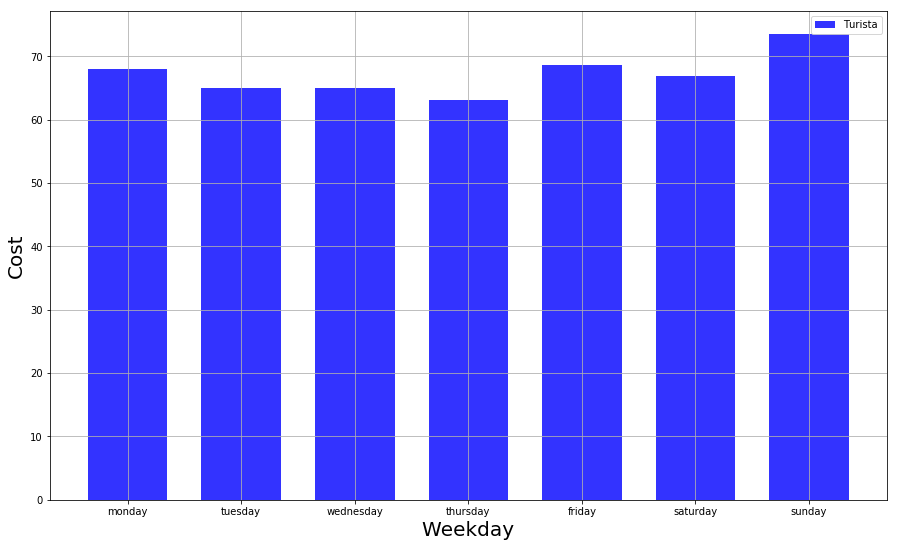

In [33]:
n_groups = 7
meansTur = list(apwTurLowest.values())
    
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
index = np.arange(n_groups)
bar_width = 0.7/1
opacity = 0.8

rects1 = plt.bar(index, meansTur, bar_width,
alpha=opacity,
color='b',
label='Turista')

plt.xticks(index, list(apwPref.keys()))
ax.grid(True)
plt.legend()
plt.xlabel('Weekday', fontsize = 20)
plt.ylabel('Cost', fontsize = 20)
plt.show()

We create separate data sets delimiting start dates in five time periods of the day

In [34]:
apwTurEM = averageLowestPerWeekday(stageDatesTur.loc[stageDatesTur['start_date'].apply(getHour) < 8])
apwTurLM = averageLowestPerWeekday(stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) < 12) &
                                          (stageDatesTur['start_date'].apply(getHour) >= 8)])
apwTurEA = averageLowestPerWeekday(stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) < 16) &
                                          (stageDatesTur['start_date'].apply(getHour) >= 12)])
apwTurLA = averageLowestPerWeekday(stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) < 19) &
                                          (stageDatesTur['start_date'].apply(getHour) >= 16)])
apwTurEE = averageLowestPerWeekday(stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) < 22) &
                                          (stageDatesTur['start_date'].apply(getHour) >= 19)])
apwTurLE = averageLowestPerWeekday(stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) >= 22)])

spwTurEM = stdLowestPerWeekday(stageDatesTur.loc[stageDatesTur['start_date'].apply(getHour) < 8])
spwTurLM = stdLowestPerWeekday(stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) < 12) &
                                          (stageDatesTur['start_date'].apply(getHour) >= 8)])
spwTurEA = stdLowestPerWeekday(stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) < 16) &
                                          (stageDatesTur['start_date'].apply(getHour) >= 12)])
spwTurLA = stdLowestPerWeekday(stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) < 19) &
                                          (stageDatesTur['start_date'].apply(getHour) >= 16)])
spwTurEE = stdLowestPerWeekday(stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) < 22) &
                                          (stageDatesTur['start_date'].apply(getHour) >= 19)])
spwTurLE = stdLowestPerWeekday(stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) >= 22)])

We graph the results in a bar graph

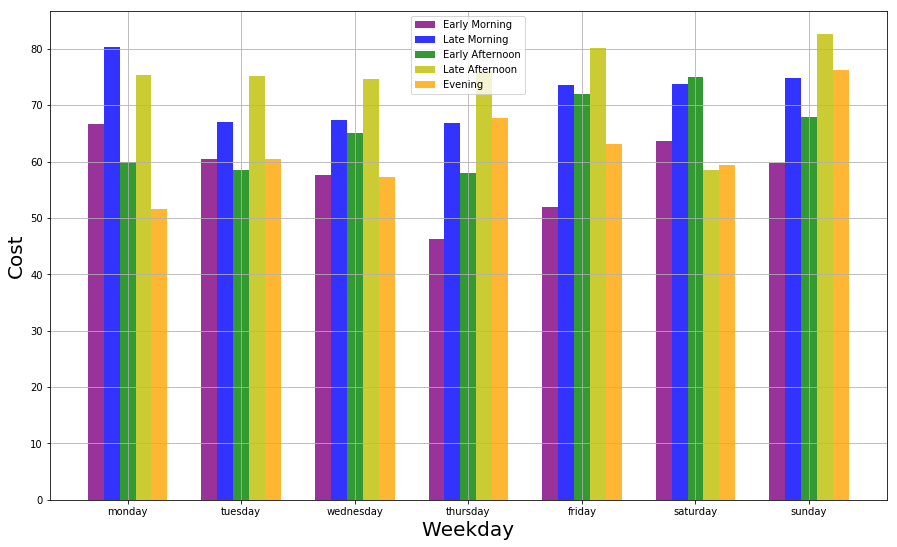

In [35]:
n_groups = 7
meansTurEM = list(apwTurEM.values())
meansTurLM = list(apwTurLM.values())
meansTurEA = list(apwTurEA.values())
meansTurLA = list(apwTurLA.values())
meansTurEE = list(apwTurEE.values())
#meansTurLE = list(apwTurLE.values())
    
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
index = np.arange(n_groups)
bar_width = 0.7/5
opacity = 0.8

rects1 = plt.bar(index, meansTurEM, bar_width,
alpha=opacity,
color='purple',
label='Early Morning')

rects2 = plt.bar(index + bar_width, meansTurLM, bar_width,
alpha=opacity,
color='b',
label='Late Morning')

rects3 = plt.bar(index + 2*bar_width, meansTurEA, bar_width,
alpha=opacity,
color='g',
label='Early Afternoon')

rects4 = plt.bar(index + 3*bar_width, meansTurLA, bar_width,
alpha=opacity,
color='y',
label='Late Afternoon')

rects5 = plt.bar(index + 4*bar_width, meansTurEE, bar_width,
alpha=opacity,
color='orange',
label='Evening')

# rects6 = plt.bar(index + 5*bar_width, meansTurLE, bar_width,
# alpha=opacity,
# color='r',
# label='Preferente')

plt.xticks(index + 2*bar_width, list(apwPref.keys()))
ax.grid(True)
plt.legend()
plt.xlabel('Weekday', fontsize = 20)
plt.ylabel('Cost', fontsize = 20)
plt.show()

Note that generally, early morning and night trains are cheaper

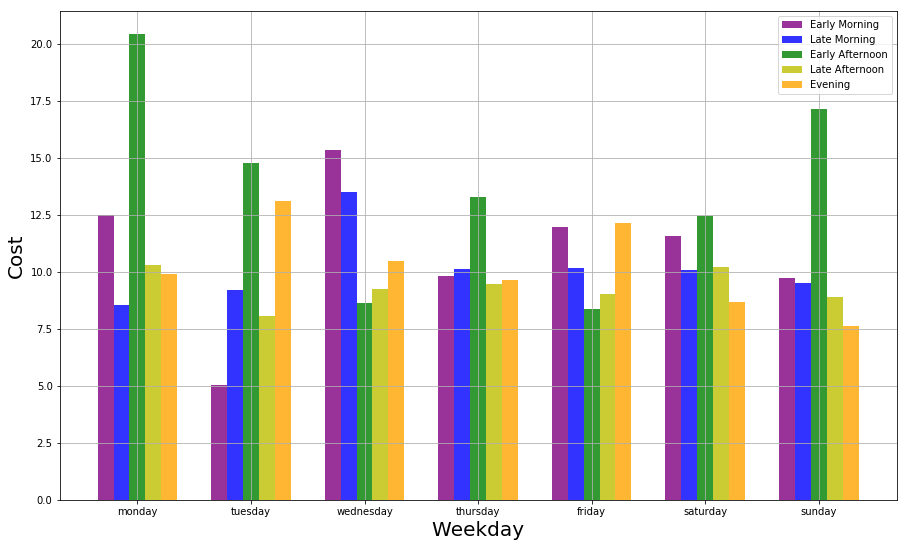

In [36]:
n_groups = 7
stdTurEM = list(spwTurEM.values())
stdTurLM = list(spwTurLM.values())
stdTurEA = list(spwTurEA.values())
stdTurLA = list(spwTurLA.values())
stdTurEE = list(spwTurEE.values())
#meansTurLE = list(apwTurLE.values())
    
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
index = np.arange(n_groups)
bar_width = 0.7/5
opacity = 0.8

rects1 = plt.bar(index, stdTurEM, bar_width,
alpha=opacity,
color='purple',
label='Early Morning')

rects2 = plt.bar(index + bar_width, stdTurLM, bar_width,
alpha=opacity,
color='b',
label='Late Morning')

rects3 = plt.bar(index + 2*bar_width, stdTurEA, bar_width,
alpha=opacity,
color='g',
label='Early Afternoon')

rects4 = plt.bar(index + 3*bar_width, stdTurLA, bar_width,
alpha=opacity,
color='y',
label='Late Afternoon')

rects5 = plt.bar(index + 4*bar_width, stdTurEE, bar_width,
alpha=opacity,
color='orange',
label='Evening')

# rects6 = plt.bar(index + 5*bar_width, meansTurLE, bar_width,
# alpha=opacity,
# color='r',
# label='Preferente')

plt.xticks(index + 2*bar_width, list(apwPref.keys()))
ax.grid(True)
plt.legend()
plt.xlabel('Weekday', fontsize = 20)
plt.ylabel('Cost', fontsize = 20)
plt.show()

The results are overall better, but there is a notably big spikes of variation on Monday afternoons.

We get a closer look at the data on those days.

In [37]:
stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) < 16) & 
                  (stageDatesTur['start_date'].apply(getHour) >= 12) & 
                  (stageDatesTur['weekday'] == 'monday')]

,start_date,lowest_price,weekday
231,2019-05-20 14:00:00,75.39,monday
232,2019-05-20 14:30:00,75.39,monday
233,2019-05-20 15:00:00,75.39,monday
310,2019-05-13 14:00:00,66.75,monday
311,2019-05-13 14:30:00,66.75,monday
312,2019-05-13 15:00:00,66.75,monday
313,2019-05-13 15:30:00,66.75,monday
417,2019-05-06 14:00:00,75.4,monday
418,2019-05-06 15:00:00,68.65,monday
515,2019-04-29 14:00:00,58.45,monday


In [38]:
#stageDatesTur.loc[(stageDatesTur['start_date'].apply(getHour) < 12) &
#                  (stageDatesTur['start_date'].apply(getHour) >= 8) & 
#                  (stageDatesTur['weekday'] == 'wednesday')]

### To do: maybe play around with window width, time periods

### To do: Do this for other train classes, train types (?), destinations